Extra Installation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflowjs # Converting the model to .json

     |████████████████████████████████| 71kB 6.1MB/s 


Imports

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

Constants

In [ ]:
DATASET_PATH = '/content/drive/MyDrive/HistopathologicalAnalysisUsingDeepLearning/datasets'
BATCH_SIZE = 32
IMAGE_SIZE = (50, 50)
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

file_path = 'model/model.h5'

In [ ]:
os.listdir(DATASET_PATH)

['1.tar.gz', '0.tar.gz']

In [ ]:
#!rm -r idc_dataset
!mkdir idc_dataset
!tar -xf {DATASET_PATH}/0.tar.gz -C idc_dataset
!tar -xf {DATASET_PATH}/1.tar.gz -C idc_dataset

In [ ]:
print("IDC POSITIVE : ", len(os.listdir('idc_dataset/1')))
print("IDC NEGATIVE : ", len(os.listdir('idc_dataset/0')))

IDC POSITIVE :  78786
IDC NEGATIVE :  198738


**REFERENCE**

[Image dataset from directory API Reference](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='idc_dataset',
    labels='inferred',
    label_mode='binary',
    class_names=['0', '1'],
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=121,
    validation_split=0.22,
    subset='training',
    interpolation='bilinear',
    follow_links=False   
)

Found 277524 files belonging to 2 classes.
Using 216469 files for training.


In [ ]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='idc_dataset',
    labels='inferred',
    label_mode='binary',
    class_names=['0', '1'],
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=121,
    validation_split=0.22,
    subset='validation',
    interpolation='bilinear',
    follow_links=False   
)

Found 277524 files belonging to 2 classes.
Using 61055 files for validation.


**REFERENCE**

[Cardinality API Reference](https://www.tensorflow.org/api_docs/python/tf/data/experimental/cardinality)

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take(val_batches // 5)
validation_ds = validation_ds.skip(val_batches // 5)

In [ ]:
print("Number of batches in Training Dataset : %d"%tf.data.experimental.cardinality(train_ds))
print("Number of batches in Validation Dataset : %d"%tf.data.experimental.cardinality(validation_ds))
print("Number of batches in Test Dataset : %d"%tf.data.experimental.cardinality(test_ds))

Number of batches in Training Dataset : 6765
Number of batches in Validation Dataset : 1527
Number of batches in Test Dataset : 381


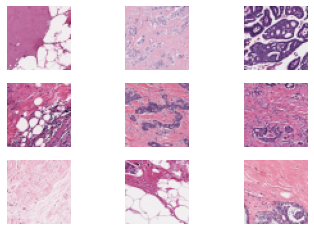

In [ ]:
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.axis("off")

**REFERENCE**

[Data Performance](https://www.tensorflow.org/guide/data_performance)

In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

**REFERENCE**

[Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)
  # Batch all datasets
  # ds = ds.batch(BATCH_SIZE)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
  
  return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, shuffle=True, augment=True)
validation_ds = prepare(validation_ds)
test_ds = prepare(test_ds)

**REFERENCE**

[CNN Theory](https://www.youtube.com/watch?v=m8pOnJxOcqY)

**Layers API Reference**

[conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)

[MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)

[Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)

[Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)

[Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)

In [ ]:
model = tf.keras.Sequential([
    layers.Conv2D(first_filters, kernel_size, activation='relu', input_shape=(50, 50 , 3)),
    layers.Conv2D(first_filters, kernel_size, activation='relu'),
    layers.Conv2D(first_filters, kernel_size, activation='relu'),
    layers.MaxPooling2D(pool_size = pool_size),
    layers.Dropout(dropout_conv),

    layers.Conv2D(second_filters, kernel_size, activation='relu'),
    layers.Conv2D(second_filters, kernel_size, activation='relu'),
    layers.Conv2D(second_filters, kernel_size, activation='relu'),
    layers.MaxPooling2D(pool_size = pool_size),
    layers.Dropout(dropout_conv),

    layers.Conv2D(third_filters, kernel_size, activation ='relu'),
    layers.Conv2D(third_filters, kernel_size, activation ='relu'),
    layers.Conv2D(third_filters, kernel_size, activation ='relu'),
    layers.MaxPooling2D(pool_size = pool_size),
    layers.Dropout(dropout_conv),

    layers.Flatten(),
    layers.Dense(256, activation = "relu"),
    layers.Dropout(dropout_dense),
    layers.Dense(1, activation = "sigmoid")
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 64)       

**REFERENCE**

[Model Reference](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

In [ ]:
model.compile(
    Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC', 'FalseNegatives', 'FalsePositives', 'TruePositives', 'TrueNegatives', 'Precision', 'Recall']
)

In [ ]:
checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto', restore_best_weights=True)

callbacks_list = [checkpoint, reduce_lr, earlyStopping]

In [ ]:
history = model.fit(train_ds,
                    validation_data=validation_ds,
                    epochs=60,
                    verbose=1,
                   callbacks=callbacks_list)

Epoch 1/60
6765/6765 [==============================] - 384s 51ms/step - loss: 0.4030 - accuracy: 0.8257 - auc: 0.8623 - false_negatives: 24476.0000 - false_positives: 13246.0000 - true_positives: 36905.0000 - true_negatives: 141842.0000 - precision: 0.7359 - recall: 0.6012 - val_loss: 0.3585 - val_accuracy: 0.8475 - val_auc: 0.8979 - val_false_negatives: 4535.0000 - val_false_positives: 2916.0000 - val_true_positives: 9502.0000 - val_true_negatives: 31910.0000 - val_precision: 0.7652 - val_recall: 0.6769

Epoch 00001: val_accuracy improved from -inf to 0.84751, saving model to model/model.h5
Epoch 2/60
6765/6765 [==============================] - 296s 41ms/step - loss: 0.3548 - accuracy: 0.8481 - auc: 0.8978 - false_negatives: 19849.0000 - false_positives: 13042.0000 - true_positives: 41532.0000 - true_negatives: 142046.0000 - precision: 0.7610 - recall: 0.6766 - val_loss: 0.3361 - val_accuracy: 0.8571 - val_auc: 0.9134 - val_false_negatives: 3517.0000 - val_false_positives: 3466.0000

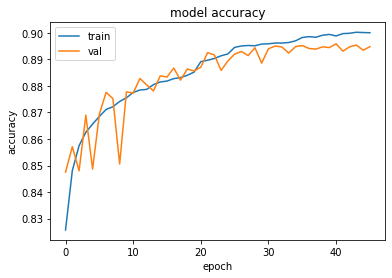

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

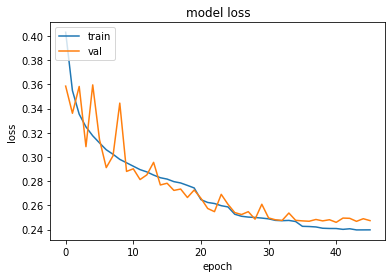

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

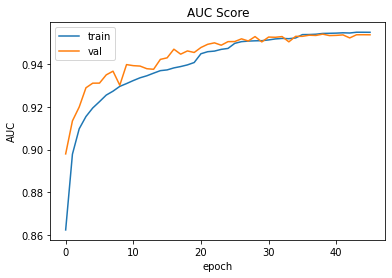

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('AUC Score')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

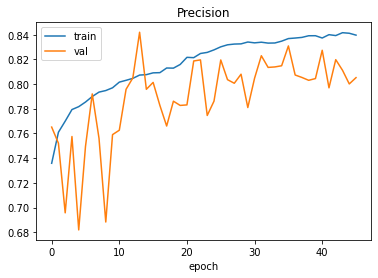

In [ ]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

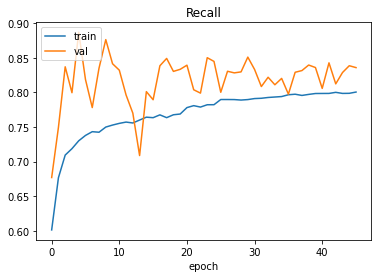

In [ ]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
f1_score = 2 * ((history.history['precision'][-1] * history.history['recall'][-1]) / (history.history['precision'][-1] + history.history['recall'][-1]))
print("F1 Score", f1_score)

F1 Score 0.8195405714372016


In [ ]:
results = model.evaluate(test_ds, verbose=2)
print(results)

381/381 - 15s - loss: 0.2567 - accuracy: 0.8920 - auc: 0.9483 - false_negatives: 676.0000 - false_positives: 641.0000 - true_positives: 2691.0000 - true_negatives: 8184.0000 - precision: 0.8076 - recall: 0.7992
[0.25674596428871155, 0.8919783234596252, 0.9483441114425659, 676.0, 641.0, 2691.0, 8184.0, 0.807623028755188, 0.799227774143219]


In [ ]:
!tensorflowjs_converter --input_format keras model/model.h5 model

2021-06-18 19:06:50.981589: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
